In [2]:
# Packages for calculations
import pandas as pd
print('Pandas version is %s' % pd.__version__)
import numpy as np
print('NumPy version is %s' % np.__version__)
import statsmodels.api as sm
print('Statsmodels version is %s' % sm.__version__)
import scipy.stats as stats
from cogstat import cogstat as cs
print('CogStat version is %s' % cs.__version__)

# Packages for visualizations
import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib version is %s' % matplotlib.__version__)
import seaborn as sns
print('Seaborn version is %s' % sns.__version__)
%matplotlib inline

print('Imports done.')


Pandas version is 2.0.1
NumPy version is 1.24.3
Statsmodels version is 0.13.2
CogStat version is 2.4beta
Matplotlib version is 3.7.1
Seaborn version is 0.12.2
Imports done.


# Introduction
Welcome to the task reliability analysis notebook! This script is intended to help researchers analyize the reliability of their experimental task data.

## Importing your data
The first step in using the analysis script is to import your data. To do this, copy the file path leading to your data file to the “path” variable in the “Analysis setup” cell. Note that your data should be long form, i.e., each row should represent one experimental trial.

## Analysis set up
In the “Analysis setup” cell, you need to declare all variables of interest. The variables “rt” and “error” should be the names of the columns containing reaction time and error data, respectively. The “response var” variable is the variable you want to use for computing your effect sizes, while “participant_var” and “condition_var” are the columns containing participant IDs and experimental conditions for each trial, respectively.

After this, you also need to set the analysis parameters of your choice as discussed below.

### Reliability analyses - Split-half relieability
Set "reliability_type" to one of the values below to run the appropriate analysis
##### Reliability metrics based on Pronk et al., 2021:

"stratified" - Stratified even-odd split-half reliability with Spearman-Brown correction.

"permutation_trial" - Resampling trials without replacement to test a large number of possible splits. Repeated n times.

##### Other reliability metrics:

"permutation_participant" - Resampling participants (instead of trials) without replacement, uses Spearman-Brown correction. Repeated n times.

"monte_carlo_participant" - Resampling participants (instead of trials) with replacement, uses Spearman-Brown correction. Repeated n times.

### Reliability analyses - Intraclass correlations (ICC)
We provide three ICCs: ICC(1), ICC(A,1) and ICC(C,1). To interpret the three ICC values, you can use the guidelines provided by Liljequist and colleagues (2021): When all three values are approximately equal, there are no meaningful systematic biases between measurements and ICC(1) should be used. When the three values are different, biases are likely present between measurements. In this case ICC(1) should not be used and in most cases ICC(A,1) should used instead. ICC(C,1) can be interpreted as the estimate of what ICC(A,1) would be in case of no bias. ICC(C,1) can also be used when measurement biases are of no concern to you.

### Effect size calcuations
You need to specify what kind of effect size estimates to use in the reliabiltiy analysis as well as in estimating individual effect sizes by setting "effect_size_method" to one of the values below.

"differences" - Aggregate data in "response_var" using either the mean or median (as declared in "aggfunc"). Calculate the differences between two conditions (as declared in "conditions" and "condition_var") for each participant.

"d_prime" - Calculate the d' index from signal detection theory. The first value in "conditions" should be the signal present condition and the second the signal absent condition.

"slope" - Calculate the slope of the regression line for each participant, where the dependent variable is "response_var" and the independent variable is "condition_var". When only two experimental conditions have been used, the slope is equivalent to the difference of means. Note that to calculate slopes, "condition_var" has to contain numerical values.


# Functions

## Top-level functions used
This notebook contains a lot of functions, however the key analyses are contained in three top-level functions:
### effect_size_analysis()
The effect_size_analysis() function calls the effect_size_resampling() function to to perform bootstrapping on the trial data in order to calculate the point and interval estimates of each participant's respective effect size. It then displays some descriptive values on the degree of overlap between participant effect sizes, and shows a plot with the point estimates and 95% confidence intervals for each participant.

The function takes a number of arguments that are each defined in the "Analysis setup" cell:

n - the number of resamlings to perform, 

df - the dataframe (here defined already), 

effect_size_method - the effect size metric you want to calculate, 

participant_var - the name of the columns containing participant IDs, 

response_var - the name of the column containing the response variable used to calculate effect sizes, 

condition_var - the name of the column containing the experimental conditions for each trial, 

conditions - the labels of the two conditions used to calculate "d_prime" and "differences" (default value is None), 

aggfunc - whether to calculate mean or median when using "differences (default value is "mean") 

and display_data - whether or not to display the numerical effect size estimates for each participant (default is False)
### reliability_analysis()
The reliability_analysis() function performs the split-half reliability analyses using one of the metrics mentioned above. The function calls the stratified_splithalf() function for "stratified", and bootstrapping_loop() for all resampling methods. The output contains a point estimate and 95% interval, as well as a plot showing the resampling deistribution of reliability coefficients when using resampling methods.

The function takes a number of arguments that are each defined in the "Analysis setup" cell:

df - the dataframe (here defined already), 

effect_size_method - the effect size metric you want to calculate, 

reliability_type - the type of split-half reliability metric to calculate,

participant_var - the name of the columns containing participant IDs, 

response_var - the name of the column containing the response variable used to calculate effect sizes,  

condition_var - the name of the column containing the experimental conditions for each trial,  

conditions - the labels of the two conditions used to calculate "d_prime" and "differences" (default value is None),  

aggfunc - whether to calculate mean or median when using "differences (default value is "mean"), 

nonparametric - whether to use Pearson correlations when calculating reliability (False), or Spearman's correlation (True), default is False.

n  - the number of resamlings to perform (default value is None, as "stratified" doesn't perform resampling)
### cs_icc()
The cs_icc() function performs a stratified split by calling assign_even_odd() the same way as reliability_analysis(). However, instead of correlating the two sets of effect sizes, it calls the interrater_reliability() function from the CogStat statistical package to calculate ICCs. The package also provides a context for the interpretation of the ICCs by displaying charts, performing assumption checks in line with McGraw & Wong (1996) as well as calculating confidence intervals and hypothesis tests.

The function takes a number of arguments that are each defined in the "Analysis setup" cell:

data - the dataframe (here defined already), 

effect_size_method - the effect size metric you want to calculate, 

participant_var - the name of the columns containing participant IDs, 

response_var - the name of the column containing the response variable used to calculate effect sizes, 

condition_var - the name of the column containing the experimental conditions for each trial,   

conditions - the labels of the two conditions used to calculate "d_prime" and "differences" (default value is None),   

aggfunc - whether to calculate mean or median when using "differences (default value is "mean"), 

In [5]:
### Functions ###
### Reading in the data and displaying some properties ###

def read_data(path):
    """
    Read in data from given path.

    Parameters
    ----------
    path: str
        The filepath

    Returns
    -------
    data: pandas dataframe
    
    """
    extension = path.split(".")[1]
    if extension == "xlsx":
        data = pd.read_excel(path)
    elif extension == "csv":
        data = pd.read_csv(path)
    else:
        data=None
        print("Please provide your data in csv or xlsx format.")
    return data

def n_trials(data, participant, condition_var):
    """
    Display number of trials per participant and per condition as a bar graph.

    Parameters
    ----------
    data: pandas dataframe
    participant: str
        Name of column containing pariticipant IDs.
    condition_var: str
        Name of column containing experimental condition.

    """
    data["index"] = range(len(data))
    data_check = pd.pivot_table(data=data, index=participant, columns=condition_var, values="index", aggfunc='count')
    data_check_long = data_check.melt(ignore_index=False)
    data_check_long.reset_index(inplace=True)

    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle("Number of trials per participant per condition")
    sns.barplot(data=data_check_long, x=participant, y="value", hue=condition_var, ax=ax)
    plt.ylabel('n trials')
    plt.xticks(rotation=90)
    plt.show()


### Calculate effect sizes ###

def aggregate(data, method):
    """
    Aggregate data using mean or median.

    Parameters
    ----------
    data: pandas dataframe
    method: {"mean", "median"}

    Returns
    -------
    float
    """
    if method == "mean":
        result = np.mean(data)
    elif method == "median":
        result = np.median(data)
    return result

def edge_correction(proportion, all):
    """
    Perform edge-correction to avoid infinite values in d-prime calculations.
    Ref: Macmillan, N. A., & Creelman, C. D. (2004). Detection Theory: A User's Guide. Psychology Press.
    Also see: https://lindeloev.net/calculating-d-in-python-and-php/

    Parameters
    ----------
    proportion : float
        Quantity to check.
    all: float
        Quantity to use in correction, e.g. hits + misses, false alarms + correct rejections, etc.

    Returns
    -------
    float
    
    """

    if proportion >= 1:
        proportion = 1 - (0.5/all)
    elif proportion <= 0:
        proportion = 0.5/all
    return proportion

def d_prime(data, participant_var, condition_var, conditions, response_var):
    """
    Calculate d-prime as the difference in the z-transformed proportions of hits and false alarms.
    Ref: Macmillan, N. A., & Creelman, C. D. (2004). Detection Theory: A User's Guide. Psychology Press.

    Parameters
    ----------
    data : dataframe
    participant_var: str
        Name of column containing pariticipant IDs.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        List of length 2, containing experimental conditions in condition_var column to examine. 
        First value is signal present, second value is signal absent.
    response_var: str
        Name of the column containing the response variable.

    Returns
    -------
    dataframe
        Dataframe containing a column for participant ID and a column for their respective d-prime values.
    
    """

    discrimination_list = []
    for id in data[participant_var].unique():
        # Looping through each participant's data
        data_participant = data[data[participant_var]==id]
        signal_present = data_participant[data_participant[condition_var]==conditions[0]]
        signal_absent = data_participant[data_participant[condition_var]==conditions[1]]

        # Calculate proportions
        p_hit = len(signal_present[signal_present[response_var]==1]) / len(signal_present)
        p_fa = len(signal_absent[signal_absent[response_var]==1]) / len(signal_absent)
        
        # Avoiding infinite values by edge-correction
        p_hit = edge_correction(p_hit, len(signal_present))
        p_fa = edge_correction(p_fa, len(signal_absent))
        
        discrimination = stats.norm.ppf(p_hit) - stats.norm.ppf(p_fa)
        discrimination_list.append([id, discrimination])
    discrimination_df = pd.DataFrame(discrimination_list, columns=[participant_var, 'effect_size'])
    
    return discrimination_df

def differences(data, aggfunc, participant_var, condition_var, conditions, response_var):
    """
    Calculate differences between experimental conditions for each participant.

    Parameters
    ----------
    data: pandas dataframe
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition. If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median.
    participant_var: str
        Name of column containing pariticipant IDs.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        List of length 2, containing experimental conditions in condition_var column to examine. 
        Second condition is subtracted from first.
    response_var: str
        Name of the column containing the response variable.

    Returns
    -------
    dataframe

    """
    discrimination_list = []
    for id in data[participant_var].unique():
        data_participant = data[data[participant_var]==id]
        cond0_agg = aggregate(data_participant[data_participant[condition_var]==conditions[0]][response_var], aggfunc)
        cond1_agg = aggregate(data_participant[data_participant[condition_var]==conditions[1]][response_var], aggfunc)
        difference = cond0_agg - cond1_agg
        discrimination_list.append([id, difference])
    differences_df = pd.DataFrame(discrimination_list, columns=[participant_var, "effect_size"])
    return differences_df

def slope(data, participant_var, condition_var, response_var):
    """
    Calculate effect sizes as the slope of the regression line between condition_var and response_var for each participant

    Parameters
    ----------
    data: pandas dataframe
    participant_var: str
        Name of column containing pariticipant IDs.
    condition_var: str
        Name of column containing experimental condition. Has to be at least ordinal.
    response_var: str
        Name of the column containing the response variable.

    Returns
    -------
    dataframe

    """
    slopes_list = []
    for id in data[participant_var].unique():
        data_participant = data[data[participant_var]==id]
        result = sm.OLS(np.array(data_participant[response_var]), np.array(sm.add_constant(data_participant[condition_var]), dtype=float), missing="drop").fit()
        slopes_list.append([id, result.params[1]])
    slopes_df = pd.DataFrame(slopes_list, columns=[participant_var, "effect_size"])
    return slopes_df

def effect_size_calc(data, method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean"):
    """
    Choose effect size calculation method and call appropriate function.

    Parameters
    ----------
    data: pandas dataframe
    method: {"d_prime", "differences", "slope"}
        Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of column containing pariticipant IDs.
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list
        List of experimental conditions in condition_var column to examine. First value is signal present, second value is signal absent.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median.

    Returns
    -------
    dataframe
    
    """
    if method == "d_prime":
        effect_sizes = d_prime(data, participant_var, condition_var, conditions, response_var)
    elif method == "differences":
        effect_sizes = differences(data, aggfunc, participant_var, condition_var, conditions, response_var)
    elif method == "slope":
        effect_sizes = slope(data, participant_var, condition_var, response_var)

    return effect_sizes

def effect_size_resampling(n, data, effect_size_method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean"):
    """
    Calculate individual effect size distributions for each participant with bootstrapping. 
    Returns point estimate, 95% CI and the complete effect size distribution.

    Parameters
    ----------
    n: int
        Number of resamplings to perform.
    data: pandas dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list
        List of experimental conditions in condition_var column to examine. First value is signal present, second value is signal absent.
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".
    
    Returns
    -------
    dataframe
        Effect sizes for each participant in each subsample.
    dataframe
        Average effect sizes and 95% CIs for each participant.
    """
    effect_size_dist_df = pd.DataFrame(columns=[participant_var, "effect_size"])
    effect_size_summary_list = []
    for i in range(n):
        print(i, end=" ")
        subsample = pd.DataFrame(columns=data.columns)
        for id in data[participant_var].unique():
            subsample_id = data[data[participant_var]==id].sample(frac=1.0, replace=True)
            subsample = pd.concat([subsample, subsample_id])
        subsample_effect_sizes = effect_size_calc(subsample, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)
        effect_size_dist_df = pd.concat([effect_size_dist_df, subsample_effect_sizes], ignore_index=True)
    for id in effect_size_dist_df[participant_var].unique():
        data_participant = effect_size_dist_df[effect_size_dist_df[participant_var]==id]
        effect_size_summary_list.append([id, np.mean(data_participant["effect_size"]), 
                                         np.percentile(data_participant["effect_size"], 2.5), 
                                         np.percentile(data_participant["effect_size"], 97.5)])

    effect_size_summary_df = pd.DataFrame(effect_size_summary_list, columns=[participant_var, "effect_size", "CI_low", "CI_high"])

    return effect_size_dist_df, effect_size_summary_df


### Calculate reliability ###

def correl_ci(coefficient, CI, data):
    """
    Calculate confidence interval of correlation coefficient using Fisher's Z-transform.
    
    Paramters
    ----------
    coefficient: float
        The correlation coefficient.
    CI: {90, 95, 99}
        The desired confidence level.
    data: dataframe
        The dataframe from which the correlation coefficient was calculated.

    Returns
    -------
    list
        First element is the correlation coefficient, second element is the lower bound
        of the CI and the third element is the upper bound of the CI.
    
    """

    #CI transform
    if CI == 90:
        z_CI = 1.645
    elif CI == 95:
        z_CI = 1.96
    elif CI == 99:
        z_CI = 2.576
    
    #Calculate
    datan = len(data)
    z_r = 0.5 * np.log((1+coefficient) / (1-coefficient))
    z_low = z_r - z_CI * np.sqrt(1.0/(datan-3))
    z_high = z_r + z_CI * np.sqrt(1.0/(datan-3))
    
    #Convert back
    r_low = ((np.exp(2 * z_low)) - 1) / ((np.exp(2 * z_low)) + 1)
    r_high = ((np.exp(2 * z_high)) - 1) / ((np.exp(2 * z_high)) + 1)

    return [coefficient, r_low, r_high]

def assign_even_odd(data, participant_var, condition_var):
    """
    Split data into even and odd trials for each participant, with an equal number of trials 
    from each experimental condition in each half.

    Parameters
    ----------
    data: dataframe
    participant: string
        Name of the column holding participant names
    condition_var: str
        Name of column containing experimental condition.

    Returns
    -------
    dataframe
        The data containing even numbered trials
    dataframe
        The data containing odd numbered trials
    dataframe
        The original data
    """
    data_sorted = pd.DataFrame()
    for id in data[participant_var].unique():
        data_participant = data[data[participant_var] == id].sort_values(condition_var)  # Stratified even-odd (Pronk, 2021)
        splitter = np.empty((len(data_participant),))
        splitter[::2] = 1
        splitter[1::2] = 0
        splitting_list = splitter.tolist()
        data_participant.loc[:,'split_var'] = splitting_list
        data_sorted = pd.concat([data_sorted, data_participant])

    data_even = data_sorted[data_sorted['split_var']==0]
    data_odd = data_sorted[data_sorted['split_var']==1]

    return data_even, data_odd, data

def stratified_splithalf(data, effect_size_method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean", correction=True, nonparametric=False):
    """
    Calculate stratified split-half reliability with Spearman-Brown correction.

    Parameters
    ----------
    data: dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        A 2 elemnt list of experimental conditions in condition_var column to examine when using "differences" or "d_prime".
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".
    correction: bool
        Perform Spearman-Brown correction on split-half coefficient if True, report raw correlation value if False. Default is True.
    nonparametric: bool
        Calculate Spearman's rank-order correlation if True, Pearson's if False. Default is False.

    Returns
    -------
    list of float
        First element is the correlation coefficient, second element is the 
        lower bound of the CI and the third element is the upper bound of the CI.
    None
        Placeholder, since permutation approaches return two arguments.
    """
    
    data_even, data_odd, data = assign_even_odd(data, participant_var, condition_var)
    effect_sizes_even = effect_size_calc(data_even, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)
    effect_sizes_odd = effect_size_calc(data_odd, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)

    if nonparametric:
        r = stats.spearmanr(effect_sizes_even['effect_size'], effect_sizes_odd['effect_size']).correlation
    else:
        r = np.corrcoef(effect_sizes_even['effect_size'], effect_sizes_odd['effect_size'])[0][1]

    if correction:
        r = (2*r) / (1+r)  # Spearman-Brown correction
    
    result = correl_ci(r, 95, data_even)

    return result, None

def resampled_splithalf(data, effect_size_method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean", nonparametric=False, level='participant', resampling_type='monte_carlo', i=None):
    """
    Draw two samples with or without replacement from the data (on the trial or participant level) and calculate the reliabiltiy as the correlation between the 
    participant effect sizes in the two samples.

    Parameters
    ----------
    data: dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        LA 2 element list of experimental conditions in condition_var column to examine when using "differences" or "d_prime". 
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".
    nonparametric: bool
        Calculate Spearman's rank-order correlation if True, Pearson's if False
    level: {'participant', 'trial'}
        Level of resampling. If 'participant', resample participants but not trials, if 'trial', resample trials but not participants.
    resampling_type: {'monte_carlo', 'permutation'}
        If 'monte_carlo', sample with replacement with frac=1.0, if 'premutation' sample without replacement with farc=0.5 and use Spearman-Brown correction.
    i: int
        Number of iteration.

    Returns
    -------
    float
        The calculated reliabiltiy as a correlation coefficient
    dataframe
        The participant effect sizes from the two samples
    """
    if resampling_type == 'monte_carlo':
        resample_frac = 1.0
        replacement = True
    elif resampling_type == 'permutation':
        resample_frac = 0.5
        replacement = False

    if level == 'trial':
        resample_1, resample_2 = pd.DataFrame(columns=data.columns), pd.DataFrame(columns=data.columns)
        for id in data[participant_var].unique():
            data_participant = data[data[participant_var] == id]
            if resampling_type == 'monte_carlo':
                for condition in data_participant[condition_var].unique():
                    resample_1_condition = data_participant[data_participant[condition_var]==condition].sample(frac=resample_frac, replace=replacement)
                    resample_2_condition= data_participant[data_participant[condition_var]==condition].sample(frac=resample_frac, replace=replacement)
                    resample_1 = pd.concat([resample_1, resample_1_condition])
                    resample_2 = pd.concat([resample_2, resample_2_condition])
            elif resampling_type == 'permutation':
                for condition in data_participant[condition_var].unique():
                    resample_1_condition = data_participant[data_participant[condition_var]==condition].sample(frac=resample_frac, replace=replacement)
                    resample_2_condition = data_participant[data_participant[condition_var]==condition].drop(resample_1_condition.index)
                    resample_1 = pd.concat([resample_1, resample_1_condition])
                    resample_2 = pd.concat([resample_2, resample_2_condition])
        effect_sizes_1 = effect_size_calc(resample_1, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)
        effect_sizes_2 = effect_size_calc(resample_2, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)
    
    elif level == 'participant':
        data_even, data_odd, data = assign_even_odd(data, participant_var, condition_var)
        split_1_effect = effect_size_calc(data_even, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)
        split_2_effect = effect_size_calc(data_odd, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc)
        effect_sizes_1 = split_1_effect.sample(frac=resample_frac, replace=replacement)
        effect_sizes_2 = pd.DataFrame()
        for id in effect_sizes_1[participant_var]:
            effect_sizes_2 = pd.concat([effect_sizes_2, split_2_effect[split_2_effect[participant_var]==id]])

    # Calculating split-half reliability with Pearson or Spearman
    if nonparametric:
        r = stats.spearmanr(effect_sizes_1['effect_size'], effect_sizes_2['effect_size']).correlation
    else:
        r = np.corrcoef(effect_sizes_1['effect_size'], effect_sizes_2['effect_size'])[0][1]

    if (type == 'permutation') | ((type == 'monte_carlo') & (level == "participant")):
        r = (2*r) / (1+r)  # Spearman-Brown correction

    return r

def bootstrap_loop(n, data, effect_size_method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean", nonparametric=False, level='trial', resampling_type='permutation'):
    """
    Loop resampled_splithalf() n times to perform bootstrapping.

    Parameters
    ----------
    n: int
        Number of resamplings to perform
    data: dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        A 2 element list of experimental conditions in condition_var column to examine when using "differences" or "d_prime".
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".
    nonparametric: bool
        Calculate Spearman's rank-order correlation if True, Pearson's if False
    level: {'participant', 'trial'}
        Level of resampling. If 'participant', resample participants but not trials, if 'trial', resample trials but not participants.
    resampling_type: {'monte_carlo', 'permutation'}
        If 'monte_carlo', sample with replacement with frac=1.0, if 'premutation' sample without replacement with farc=0.5 and use Spearman-Brown correction.
    Returns
    -------
    list of float
        List with three elements: the average of all reliability values, the 2.5th percentile and the 97.5th percentile.
    list of float
        The correlation coefficients from each resampling.
    """

    reliability_distribution = []
    for i in range(n):
        print(i, end=" ")
        reliability = resampled_splithalf(data, effect_size_method, participant_var, response_var, condition_var, conditions, aggfunc, nonparametric, level, resampling_type, i=i)
        reliability_distribution.append(reliability)
    return [np.mean(reliability_distribution), np.percentile(reliability_distribution, 2.5), np.percentile(reliability_distribution, 97.5)], reliability_distribution

def cs_icc(data, effect_size_method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean"):
    """
    Interrater reliability analyses from CogStat (cogstat.org). ICCs calculated on a stratified split, 
    visualizations provided on the difference between splits. CIs and hypothesis tests are provided, 
    as well as the appropriate assumption tests.

    Parameters
    ----------
    data: dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        A 2 element list of experimental conditions in condition_var column to examine when using "differences" or "d_prime".
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".

    """

    data_even, data_odd, data = assign_even_odd(data, participant_var, condition_var)
    efs_even = effect_size_calc(data_even, effect_size_method, participant_var, response_var, condition_var, conditions=conditions, aggfunc=aggfunc)
    efs_odd = effect_size_calc(data_odd, effect_size_method, participant_var, response_var, condition_var, conditions=conditions, aggfunc=aggfunc)
    efs_eo = pd.concat([efs_even, efs_odd["effect_size"]], axis=1,)
    efs_eo.columns = ["online ID", "measurement_1", "measurement_2"]

    cs_data = cs.CogStatData(data=efs_eo)
    cs.display(cs_data.reliability_interrater(["measurement_1", "measurement_2"], False))


### Visualize results ###

def plot_effect_sizes(effect_size_summary, participant_var):
    """
    Plot the participant effects sizes and their 95% CIs for a given data_set and trial_type.

    Parameters
    ----------
    effect_size_summary: dataframe
        Dataframe containing 'online ID', 'd_mean', 'd_lower_diff', d_higher_diff' columns containing participant names, 
        mean effect sizes and their 95% CIs as differences from the mean, respectively
    participant_var: str
        Name of the column holding participant names

    """
    fig, ax = plt.subplots()
    effect_size_summary["CI_low_diff"] = effect_size_summary["effect_size"] - effect_size_summary["CI_low"]
    effect_size_summary["CI_high_diff"] = effect_size_summary["CI_high"] - effect_size_summary["effect_size"]
    effect_size_summary = effect_size_summary.sort_values("effect_size")
    ax.axhline(0, color='black', linewidth=1)
    ax.errorbar(x=effect_size_summary[participant_var], y=effect_size_summary["effect_size"], yerr=[effect_size_summary['CI_low_diff'],effect_size_summary['CI_high_diff']],\
        marker='o', ls='', capsize=4, capthick=2, elinewidth=2, markersize=6)  # +offset
    ax.set_xticklabels([])
    ax.tick_params('x', length=0, width=0)
    plt.xticks([]) 
    ax.set_xlabel(participant_var, fontsize=16)
    ax.set_ylabel("Effect size", fontsize=16)

def plot_reliability_distribution(distribution):
    """
    Plot the reliability distributions, mean and confidence interval for a given data_set and trial_type.

    Parameters
    ----------
    distribution: array-like
        The distribution of reliability values from the bootstrapping analysis
    
    """
    fig, ax = plt.subplots()
    sns.kdeplot(distribution, ax=ax)
    sns.rugplot(distribution, ax=ax)
    ax.set_xlim(0,1)
    ax.axvline(np.mean(distribution), color='orange')
    ax.axvline(np.percentile(distribution,2.5))
    ax.axvline(np.percentile(distribution,97.5))
    plt.xlabel('Value of r')


### Main analysis functions ###

def reliability_analysis(df, effect_size_method, reliability_type, participant_var, response_var, condition_var, conditions=None, aggfunc="mean", nonparametric=False, n=None):
    """
    Call appropriate reliability calculation function. Display reliability distribution when using resampling. For details of the analyses see the "Introduction" section above.

    Parameters
    ----------
    df: dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    reliability_type: {"stratified", "permutation_trial", "permutation_participant", "monte_carlo_participant"}
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
        A 2 element list of experimental conditions in condition_var column to examine when using "differences" or "d_prime".
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".
    nonparametric: bool
        Calculate Spearman's rank-order correlation if True, Pearson's if False
    n: int
        Number of resamplings to perform
    
    Returns
    -------
    dataframe
        Contains point estimate and 95% CI.
    list of float or None
        List of the reliability estimates from all subsamples. None when using "stratified".
    """

    data = df[[participant_var, response_var, condition_var]].dropna()
    if reliability_type == "stratified":
        result, distribution = stratified_splithalf(data, effect_size_method, participant_var, response_var, condition_var, conditions=conditions, aggfunc=aggfunc, nonparametric=nonparametric)
    elif reliability_type == "permutation_trial":
        result, distribution = bootstrap_loop(n=n, data=df, effect_size_method=effect_size_method, participant_var=participant_var, 
                                              response_var=response_var, condition_var=condition_var, conditions=conditions, aggfunc=aggfunc, 
                                              nonparametric=nonparametric, level='trial', resampling_type='permutation')
    elif reliability_type == "permutation_participant":
        result, distribution = bootstrap_loop(n=n, data=df, effect_size_method=effect_size_method, participant_var=participant_var, 
                                              response_var=response_var, condition_var=condition_var, conditions=conditions, aggfunc=aggfunc, 
                                              nonparametric=nonparametric, level='participant', resampling_type='permutation')
    elif reliability_type == "monte_carlo_participant":
        result, distribution = bootstrap_loop(n=n, data=df, effect_size_method=effect_size_method, participant_var=participant_var, 
                                              response_var=response_var, condition_var=condition_var, conditions=conditions, aggfunc=aggfunc, 
                                              nonparametric=nonparametric, level='participant', resampling_type='monte_carlo')

    result_table = pd.DataFrame([[result[0], result[1], result[2]]], columns=["reliability", "CI low", "CI high"])

    if distribution:
        plot_reliability_distribution(distribution)

    return result_table, distribution

def effect_size_analysis(n, df, effect_size_method, participant_var, response_var, condition_var, conditions=None, aggfunc="mean", display_data=False):
    """
    Run effect size analyses. For details of the analyses see the "Introduction" section above.

    Parameters
    ----------
    n: int
        Number of resamplings to perform
    df: dataframe
    effect_size_method: {"d_prime", "differences", "slope"} 
        Method for caluclateing participant effect sizes. Call d_prime() if "d_prime", differences() if "differences" and slope() if "slope".
    participant_var: str
        Name of the column holding participant names
    response_var: str
        Name of the column containing the response variable.
    condition_var: str
        Name of column containing experimental condition.
    conditions: list of str, int or float
         A 2 element list of experimental conditions in condition_var column to examine when using "differences" or "d_prime".
        Default is None.
    aggfunc: {"mean", "median"}
        How to aggregate the data within each condition when calling differences(). If "mean", calculate mean of response_var 
        for each participant in each condition. If "median" calculate the median. Default is "mean".

    Returns
    -------
    dataframe
        Effect size estimates from all subsamples.
    dataframe
        Average effect size estiamtes based on resampling, and 95% confidence intervals for each participant.
    dataframe
        Numerical descriptives on CI overlaps.
    """
    data = df[[participant_var, response_var, condition_var]].dropna()
    effect_size_dist, effect_sizes_df = effect_size_resampling(n=n, data=data, effect_size_method=effect_size_method, 
                                                               participant_var=participant_var, response_var=response_var, 
                                                               condition_var=condition_var, conditions=conditions,
                                                               aggfunc=aggfunc)

    if display_data == True:
        display(effect_sizes_df)

    effect_sizes_0 = effect_sizes_df[effect_sizes_df['CI_low']<=0]
    ci_overlap, point_overlap = [], []
    for name in effect_sizes_df[participant_var].unique():
        ci = np.array(effect_sizes_df[effect_sizes_df[participant_var]==name][['CI_low', 'CI_high']])[0]
        
        rest = effect_sizes_df[effect_sizes_df[participant_var]!=name][['effect_size', 'CI_low', 'CI_high']]
        rest['CI_overlap'] = np.where((rest['CI_low']>ci[1])|(rest['CI_high']<ci[0]),0,1)
        rest['point_overlap'] = np.where((rest['effect_size']>ci[0])&(rest['effect_size']<ci[1]), 1, 0)
        ci_overlap.append(np.sum(rest['CI_overlap'])/len(rest)*100)
        point_overlap.append(np.sum(rest['point_overlap'])/len(rest)*100)

    # Gather into dataframe
    result = pd.DataFrame([["Percent of CIs overlapping", np.mean(ci_overlap)], 
                           ["Percent of point estimates contained by CIs", np.mean(point_overlap)], 
                           ["Percent of participant CIs containing 0", len(effect_sizes_0)/len(effect_sizes_df)*100]], 
                           columns=["Measure", "Result (%)"])

    display(result)
    plot_effect_sizes(effect_sizes_df, participant_var)

    return effect_size_dist, effect_sizes_df, result

# Read in your data and display some properties
Note that only longform data is accepted, i.e. each row should represent a single experimental trial.
Please provide the path to your datafile (either in csv or xlsx format).

In [6]:
### Read in data ###
path = ""  # File path to your data
data = read_data(path)

display(data)


,online ID,MR ID,Stimuli Table,TrialIndex,TrialType,StimType,EncodingStimType,rec_trial_key.keys,rec_trial_key.rt,CurrentImage,...,DIST2_BIN,TRUE_DIST2,TRUE_DIST2_BIN,Correct,ResponseNew,rolling_avg,trial_num,outlier,data_set,ResponseOld
0,101mTRK21M,275592,2,1,OBJ,FOIL,FOIL,c,1.356678,stimuli/fractals/153a.jpg,...,3,3.026812e+02,3,1,1,NaN,0,0,data_mr_young,0
1,101mTRK21M,275592,2,2,OBJ,LURE,ERP,b,1.532706,stimuli/fractals/25b.jpg,...,2,0.000000e+00,0,0,0,NaN,1,0,data_mr_young,1
2,101mTRK21M,275592,2,3,OBJ,TARGET,ERP,c,1.720454,stimuli/fractals/62c.jpg,...,3,2.842171e-14,0,0,1,NaN,2,0,data_mr_young,0
3,101mTRK21M,275592,2,4,OBJ,LURE,ERP,b,1.995551,stimuli/fractals/73b.jpg,...,2,5.684342e-14,0,0,0,NaN,3,0,data_mr_young,1
4,101mTRK21M,275592,2,5,OBJ,FOIL,FOIL,c,1.295759,stimuli/fractals/108c.jpg,...,4,4.308871e+02,4,1,1,1.580230,4,0,data_mr_young,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,149mTRK27M,589611,4,68,OBJ,FOIL,FOIL,b,1.923023,stimuli/fractals/31a.jpg,...,4,3.715513e+02,4,0,0,1.963439,64,0,data_mr_young,1
3001,149mTRK27M,589611,4,69,OBJ,TARGET,OLP,b,2.237994,stimuli/fractals/57a.jpg,...,1,0.000000e+00,0,1,0,2.013317,65,0,data_mr_young,1
3002,149mTRK27M,589611,4,70,OBJ,LURE,ERP,b,2.233767,stimuli/fractals/52a.jpg,...,2,2.842171e-14,0,0,0,1.922405,66,0,data_mr_young,1
3003,149mTRK27M,589611,4,71,OBJ,FOIL,FOIL,b,2.048391,stimuli/fractals/115c.jpg,...,4,3.626841e+02,4,0,0,2.089901,67,0,data_mr_young,1


## Analysis setup

In [7]:
### Analysis setup ###
# Declare variables of interest
rt = "rec_trial_key.rt"  # Variable containing reaction time data.
error = "Correct"  # Variable containing error data.
response_var = "ResponseOld"  # Response variable of interest. This variable will be used to calculate effect sizes.
participant_var = "online ID"  # Variable containing participant IDs.
condition_var = "StimType"  # Variable containing the experimental condition for each trial.

# Set type of effect size and reliability calculation
reliability_type = "permutation_trial"  # Can be "stratified", "permutation_trial", "permutation_participant" and "monte_carlo_participant"
n = 10  # Set n as the number of subsamples to resample. Use 100 for preliminary results, and 1000-5000 for precise results, as this is computationally intensive.
effect_size_method = "d_prime"  # Can be "differences", "d_prime" and "slope"

# When using "differences" or "d_prime", please set "conditions" as a 2-element list. 
# The second condition will be subtracted form the first in case of "differences". 
# The first element denotes the condition where a signal is present, the second where a signal is absent 
# according to the Signal Detection Theory framework when using "d_prime".
conditions = ["TARGET", "LURE"]

aggfunc = "mean" # Set aggfunc to "mean" or "median" when using "differences"


# Display key properties of your data
In the first analysis block we display three plots highlighting certain key aspects of your data: the number of trials performed, the reaction time distributions and the participant error rates. 

The “Number of trials per participant per condition” figure shows the number of trials performed (y-axis) by each participant (x-axis), where the different colored bars denote different experimental conditions. This is an important piece of information, since reliability is greatly influenced by the number of trials performed. The figure can also be used to exclude participants with an unusually low number of trials.

The “Reaction time distribution of participants in each condition” figure shows each experimental condition in a separate plot. The x-axis denotes the measured reaction time, while the y-axis shows the probability density. Colors denote different participants. This plot can be used to detect participants who consistently perform significantly faster or slower than other participants, meaning they could be outliers. It can also be the case that all participants perform comparatively, but most of them have outlier trials, resulting in a long and thin tail of the distribution. If so, an appropriate outlier filtering technique should be employed before further analysis.

The final plot in this section is the “Error rates of participants in each condition”. Similarly to the “Number of trials per participant per condition” plot, here we see the participants on the x-axis with different colors denoting experimental conditions. The y-axis represents the average error.
In certain tasks we expect a large error rate, while in others we expect very low error rates (i.e., easier tasks). This plot can be used to assess whether this expectation holds, as well as to detect outlier participants.



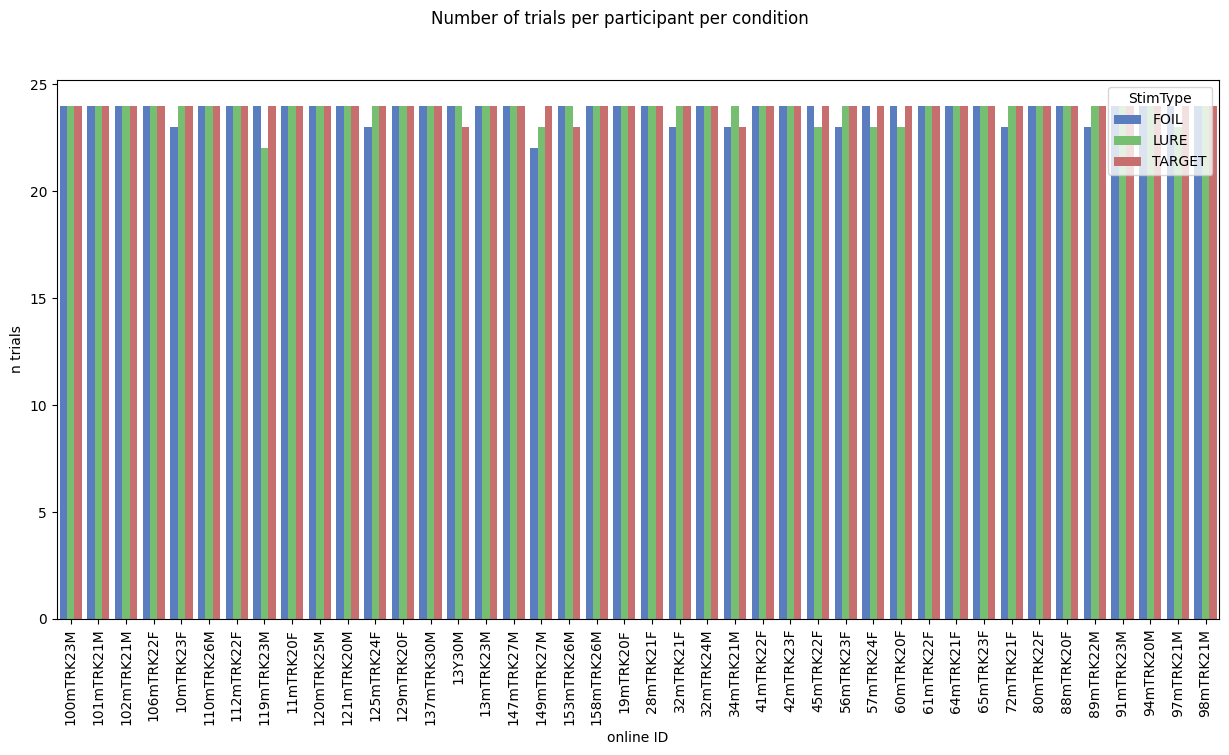

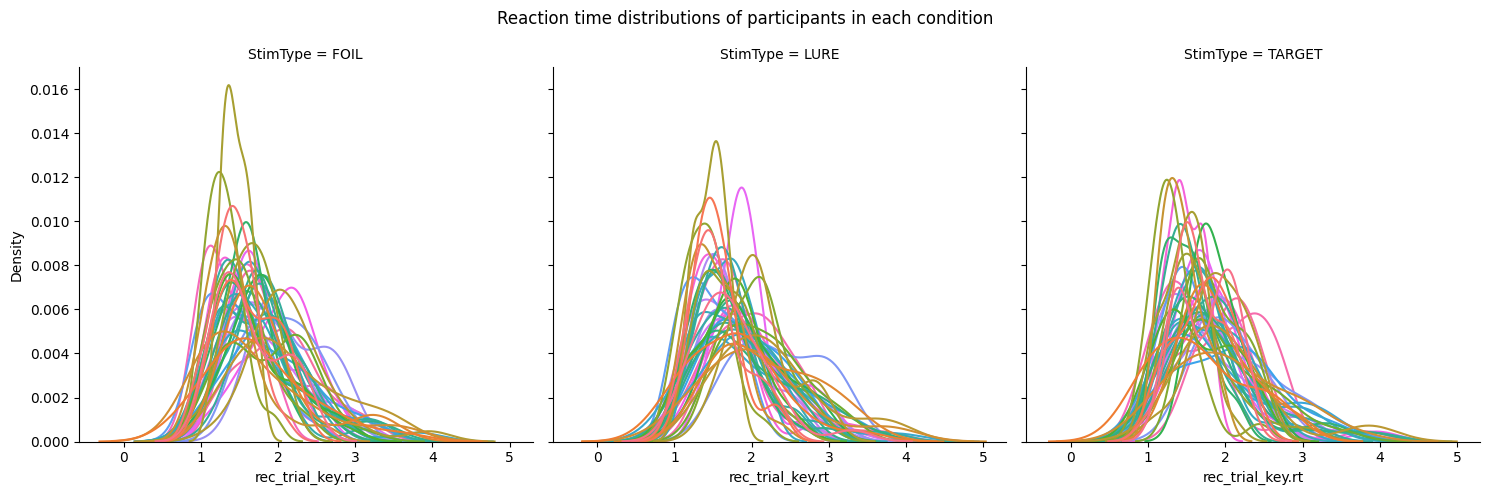

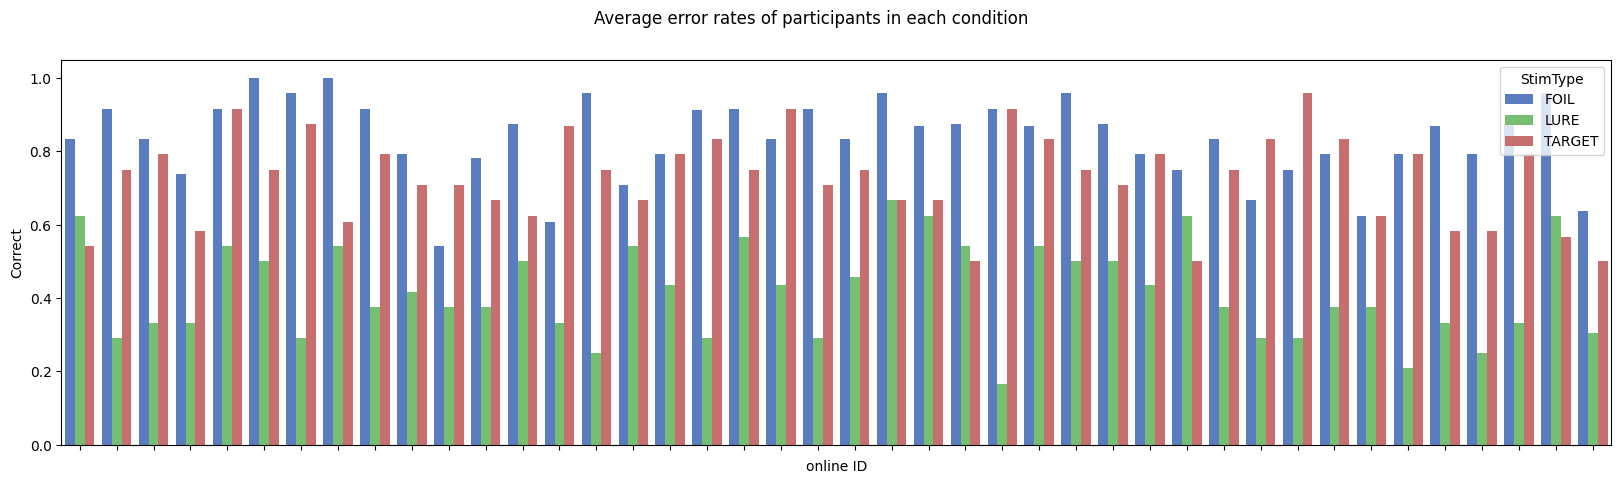

In [8]:
### Display some properties ###
# Number of trials per participant per condition
n_trials(data, participant_var, condition_var)

# RT distributions
rt_plot = sns.displot(data=data, x=rt, hue=participant_var, col=condition_var, kind="kde", legend=False)
rt_plot.fig.suptitle("Reaction time distributions of participants in each condition")
rt_plot.tight_layout()
plt.show()

# Average error per participant per condition
fig, ax = plt.subplots(figsize=[20,5])
error_plot = sns.barplot(data=data, x=participant_var, y=error, hue=condition_var, orient="v", errorbar=None, ax=ax)
ax.set_xticklabels([])
fig.suptitle("Average error rates of participants in each condition")
plt.show()

# Reliability analysis - split-half

The point estimate and 95 % confidence interval are displayed below. 

When running a resampling method (i.e. not the "stratified" method"), a plot is also provided displaying the resampling distrubtion of the reliability estimates from the caluclated random splits. The yellow vertical line denotes the mean (our point estimate), and the blue vertical lines denote the lower and upper limits of the 95 % confidence interval. The x-axis is only displayed in the [0,1] interval, as reliability below 0 is possible but generally interpreted as 0.

0 1 2 3 4 5 6 7 8 9 

,reliability,CI low,CI high
0,0.061449,-0.041124,0.191971


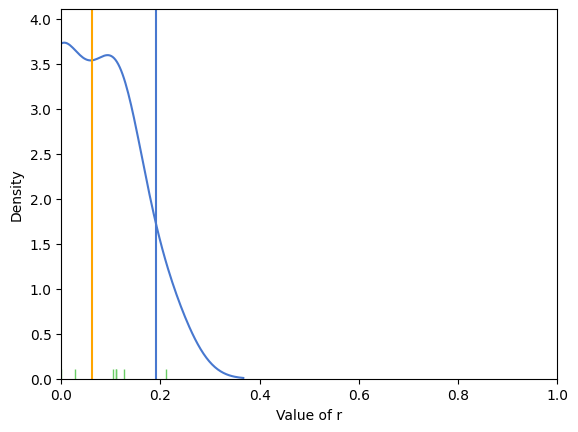

In [9]:
result_df, dist = reliability_analysis(df=data, effect_size_method=effect_size_method, reliability_type=reliability_type, 
                                   participant_var=participant_var, response_var=response_var, condition_var=condition_var, conditions=conditions, n=n)

display(result_df)

# Effect size analyses

The results of the effect size analysis are displayed below.

Percent of CIs overlapping: A participant's confidence interval overlaps with this percentage of other participant's confidence intervals to some degree.

Percent of point estimates contained by CIs: The average percentage of other participant's point estimates that a given participant's confidence interval contains.

Percent of participant CIs containing 0	: Percentage of confidence intervals containing 0. Not strictly connected to the reliability of the measurement, but can be important for the interpretation of other analysis results.

The plot shows the point estimates and 95 % confidence intervals for each participant's effect size, ordered by point estimates.

0 1 2 3 4 5 6 7 8 9 

,Measure,Result (%)
0,Percent of CIs overlapping,89.430894
1,Percent of point estimates contained by CIs,59.756098
2,Percent of participant CIs containing 0,57.142857


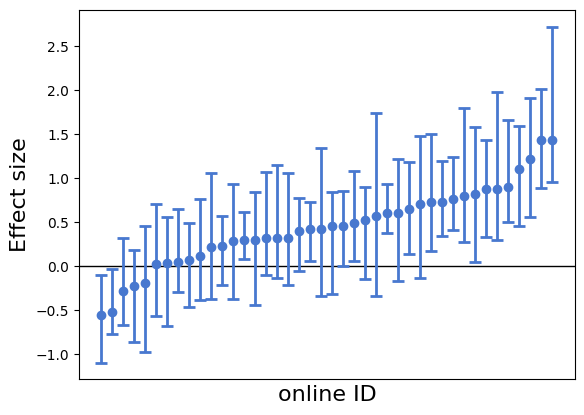

In [10]:
effect_size_dist, effect_sizes_df, result = effect_size_analysis(n, data, effect_size_method, participant_var, response_var, condition_var, conditions=conditions)

# Reliablity analysis - ICC
Interrater reliability analyses from CogStat.

We take a stratified split, as in the "stratified" split-half reliability calculations, and calculate the intraclass correlations (ICC).

Plots display the difference in the participant effect size estimates between the two splits.

ICC(1), ICC(A,1) and ICC(C,1) are provided (McGraw & Wong notation), as well as their interval estimates and hypothesis tests testing a deviation from 0. Additionally, the assumptions of confidence interval and hypothesis test calulations are tested.

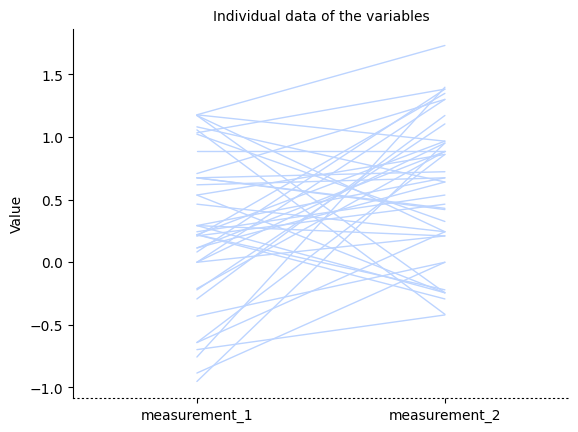

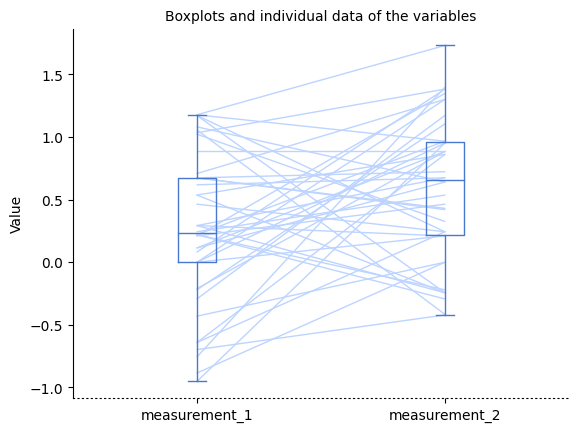

,ICC
ICC(1),-0.061
"ICC(A,1)",-0.003
"ICC(C,1)",-0.003


,Point estimation,95% confidence interval
ICC(1),-0.061,"[-0.350, 0.240]"
"ICC(A,1)",-0.003,"[-0.260, 0.270]"
"ICC(C,1)",-0.003,"[-0.300, 0.300]"


In [11]:
cs_icc(data, effect_size_method, participant_var, response_var, condition_var, conditions=conditions)
